In [20]:
## Description: Impact of management training study
# Random assignment of maangers into or not into management training
# Measure the outcome of engagement of employees from the managers
# Some managers received the training even though not assigned to it - randomization not valid


In [21]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from patsy import dmatrix
from joblib import Parallel, delayed # for parallel processing
from toolz import partial
from dowhy import CausalModel

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [22]:
# treatment is intervention, outcome is engagement_score, rest of vars are covariates
# reduce or even eliminate the bias when estimating the causal relationship between management training and employee engagement
df = pd.read_csv("management_training.csv")
df.head()

,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size
0,76,1,0.277359,6,4,2,4,0.614261,0.224077,843
1,76,1,-0.449646,4,8,2,4,0.069636,0.224077,843
2,76,1,0.769703,6,4,2,4,0.866918,0.224077,843
3,76,1,-0.121763,6,4,2,4,0.029071,0.224077,843
4,76,1,1.526147,6,4,1,4,0.589857,0.224077,843


In [23]:
df.shape

In [24]:
df.dtypes

departament_id             int64
intervention               int64
engagement_score         float64
tenure                     int64
n_of_reports               int64
gender                     int64
role                       int64
last_engagement_score    float64
department_score         float64
department_size            int64
dtype: object

In [25]:
# df['intervention'] = df['intervention'].astype('str')
df['intervention'] = df['intervention'].astype('bool')

In [26]:
df['engagement_score'].describe()

count    1.039100e+04
mean     3.829313e-17
std      1.000000e+00
min     -3.111431e+00
25%     -7.033152e-01
50%     -3.449486e-02
75%      6.724723e-01
max      3.563639e+00
Name: engagement_score, dtype: float64

#### Naive Estimate of Average Treatment Effect (ATE)

In [27]:
treatment_avg = df.loc[df['intervention'] == 1,'engagement_score'].mean()
control_avg = df.loc[df['intervention'] == 0,'engagement_score'].mean()

print('Treatment Average:', treatment_avg.round(4))
print('Control Average:',  control_avg.round(4))
print('Treatment Effect:', (treatment_avg - control_avg).round(4))

Treatment Average: 0.1999
Control Average: -0.2347
Treatment Effect: 0.4346


### DoWhy: Graphical Causal Model Model based Inference)

In [28]:
# Graph Modeling Language (GML)
nodes = ['engagement_score','intervention','tenure','last_engagement_score','department_score','department_size','n_of_reports', 'gender', 'role']
edges = [
    ('tenure', 'engagement_score'),
    ('last_engagement_score', 'engagement_score'),
    ('department_score', 'engagement_score'),
    ('department_size', 'engagement_score'),
    ('n_of_reports', 'engagement_score'),
    ('gender', 'engagement_score'),
    ('role', 'engagement_score'),
    
    ('intervention', 'engagement_score'),

    ('tenure', 'intervention'), # confounders
    ('last_engagement_score', 'intervention'),
    ('department_score', 'intervention'),
    ('department_size', 'intervention'),
    ('n_of_reports', 'intervention'),
    ('gender', 'intervention'),
    ('role', 'intervention'),

    ('n_of_reports', 'tenure'),
    ('tenure', 'role'),
    ('n_of_reports', 'role')

]

# Generate the GML graph
gml_string = 'graph [directed 1\n'
for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'
for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target"{edge[1]}"]\n'
gml_string += ']'

In [29]:
df['intervention'].unique()

array([ True, False])

In [30]:
# Can add common causes, effect modifiers, instrumental vars
# common causes = covariates, vars with more than 1 effect
model = CausalModel(
    data = df,
    treatment = 'intervention',
    outcome = 'engagement_score',
    graph=gml_string
)

Model to find the causal effect of treatment ['intervention'] on outcome ['engagement_score']


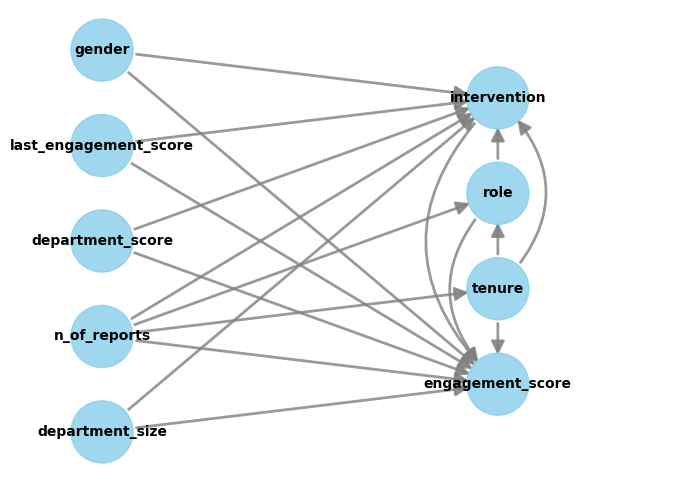

In [31]:
model.interpret()

In [32]:
estimand = model.identify_effect(proceed_when_unidentifiable=True) # proceed_when_unidentifiable ignore any unobserved confounding
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(E[engagement_score|role,n_of_reports,department_score,departme
d[intervention]                                                               

                                             
nt_size,gender,last_engagement_score,tenure])
                                             
Estimand assumption 1, Unconfoundedness: If U→{intervention} and U→engagement_score then P(engagement_score|intervention,role,n_of_reports,department_score,department_size,gender,last_engagement_score,tenure,U) = P(engagement_score|intervention,role,n_of_reports,department_score,department_size,gender,last_engagement_score,tenure)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



#### Distance Matching

In [33]:
causal_estimate_dmatch  = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.distance_matching',
    target_units='ate',
    method_params={'distance_metric': 'minkowski', 'p': 2})

print('Distance Matching ATE:', round(causal_estimate_dmatch.value,4))

Distance Matching ATE: 0.294


In [34]:
print(causal_estimate_dmatch)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(E[engagement_score|role,n_of_reports,department_score,departme
d[intervention]                                                               

                                             
nt_size,gender,last_engagement_score,tenure])
                                             
Estimand assumption 1, Unconfoundedness: If U→{intervention} and U→engagement_score then P(engagement_score|intervention,role,n_of_reports,department_score,department_size,gender,last_engagement_score,tenure,U) = P(engagement_score|intervention,role,n_of_reports,department_score,department_size,gender,last_engagement_score,tenure)

## Realized estimand
b: engagement_score~intervention+role+n_of_reports+department_score+department_size+gender+last_engagement_score

#### Linear Regression

In [35]:
causal_estimate_linreg  = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression',
    test_significance=True)

print('Linear Regression ATE:', round(causal_estimate_linreg.value,4))

Linear Regression ATE: 0.272


#### Propensity Score Stratification

In [36]:
causal_estimate_pstrat  = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_matching',
    target_units='ate')

print('Propensity Score Stratification ATE:', round(causal_estimate_pstrat.value,4))

c:\Users\arsep\anaconda3\envs\ds1\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Propensity Score Stratification ATE: 0.2914


#### Propensity Score Matching

In [37]:
causal_estimate_pmatching  = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_stratification',
    target_units='ate')

print('Propensity Score Matching ATE:', round(causal_estimate_pmatching.value,4))

Propensity Score Matching ATE: 0.3055


### Propensity Score Weighting

In [38]:
causal_estimate_weighting  = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_weighting',
    target_units='ate',
    method_params={"weighting_scheme":"ips_weight"})

print('Weighting ATE:', round(causal_estimate_weighting.value,4))

Weighting ATE: 0.3136
